In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/swis_steps_nearest_aligned (2).csv')
df.head()
df.shape

(51763, 148)

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import timedelta

# --- Configuration Layer ---
class ModelParameters:
    def __init__(self):
        self.particle_baseline_hours = 12
        self.cooldown_hours = 6
        self.high_energy_bin_start = 8
        self.high_energy_threshold = 5.0

# --- Main System Class ---
class CMEShockWarningSystem:
    def __init__(self, data_path, parameters):
        self.data_path = data_path
        self.params = parameters
        self.swis_data = None
        self.steps_data = None
        self.warnings = []
        self.flux_anomaly_history = []
        self.max_flux_anomaly_seen = 0.0

        warnings.filterwarnings("ignore", category=RuntimeWarning)
        print(f"L1 Real-Time CME Shock Warning System (v14.0 - Adaptive)")
        print("-" * 60)

    def _prepare_data_streams(self):
        print("SYSTEM: Preparing data streams...")
        try:
            df = pd.read_csv(self.data_path, parse_dates=['time']).set_index('time')
            steps_cols = [f'ep_inner_bin_{i}' for i in range(11)] + [f'ep_outer_bin_{i}' for i in range(11)]
            self.steps_data = df[steps_cols].copy().dropna(how='all')
            self.steps_data = self.steps_data.loc[self.steps_data['ep_inner_bin_0'].diff() != 0]
            self.steps_data['flux'] = self.steps_data[[f'ep_inner_bin_{i}' for i in range(11)]].sum(axis=1)
            high_cols = [f'ep_inner_bin_{i}' for i in range(self.params.high_energy_bin_start, 11)]
            self.steps_data['high_energy_flux'] = self.steps_data[high_cols].sum(axis=1)
            self.steps_data = self.steps_data[self.steps_data['flux'] > 1e-5].copy()
            print(f"  - SUCCESS: STEPS: {len(self.steps_data)} valid points.")

            swis_cols = ['proton_density_blk', 'proton_thermal_blk', 'proton_bulk_speed_blk']
            self.swis_data = df[swis_cols].copy()
            for col in swis_cols:
                self.swis_data[col] = self.swis_data[col].mask(self.swis_data[col] == -1.0e31, np.nan)
            self.swis_data.dropna(inplace=True)
            print(f"  - SUCCESS: SWIS: {len(self.swis_data)} valid points.")
            return True
        except Exception as e:
            print(f"  - FATAL ERROR: {e}")
            return False

    def run_warning_simulation(self):
        if not self._prepare_data_streams(): return
        print("\n" + "="*60)
        print("Starting Warning Simulation...")
        print("="*60 + "\n")

        baseline_steps = int(self.params.particle_baseline_hours * 6)
        active_persistence_counter = 0
        cooldown_until_index = -1

        for i in range(baseline_steps, len(self.steps_data)):
            if i <= cooldown_until_index:
                self.flux_anomaly_history.append((self.steps_data.index[i], 1.0))
                continue

            baseline_window = self.steps_data.iloc[i - baseline_steps:i]
            quiet_flux_baseline = baseline_window['flux'].median()
            quiet_flux_std = baseline_window['flux'].std()
            quiet_flux_iqr = baseline_window['flux'].quantile(0.75) - baseline_window['flux'].quantile(0.25)
            percentile_90 = baseline_window['flux'].quantile(0.90)

            dynamic_threshold = quiet_flux_baseline + 1.5 * quiet_flux_iqr
            current_flux = self.steps_data['flux'].iloc[i]
            anomaly_score = current_flux / (quiet_flux_baseline + 1e-9)

            self.flux_anomaly_history.append((self.steps_data.index[i], anomaly_score))
            if anomaly_score > self.max_flux_anomaly_seen:
                self.max_flux_anomaly_seen = anomaly_score

            if current_flux >= dynamic_threshold:
                active_persistence_counter += 1
            else:
                active_persistence_counter = 0

            dynamic_persistence = 2 if quiet_flux_std < 0.3 * quiet_flux_baseline else 4

            if active_persistence_counter >= dynamic_persistence:
                warning_time = self.steps_data.index[i]
                window_start_idx = i - active_persistence_counter + 1
                window_df = self.steps_data.iloc[window_start_idx:i+1]
                duration_minutes = (window_df.index[-1] - window_df.index[0]).total_seconds() / 60
                peak_flux = window_df['flux'].max()
                flux_integral = window_df['flux'].sum()
                avg_high_energy_flux = window_df['high_energy_flux'].mean()

                cooldown_minutes = min(30, max(10, int(duration_minutes / 2)))
                cooldown_steps = int(cooldown_minutes / 10)

                warning = {
                    'warning_time_utc': warning_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'event_window_start': window_df.index[0].strftime('%Y-%m-%d %H:%M:%S'),
                    'event_window_end': warning_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'duration_minutes': round(duration_minutes, 2),
                    'particle_flux_anomaly': f'{anomaly_score:.1f}x background',
                    'peak_flux_in_event_window': round(peak_flux, 2),
                    'flux_integral': round(flux_integral, 2),
                    'high_energy_flux_avg': round(avg_high_energy_flux, 2),
                    'baseline_std': round(quiet_flux_std, 3),
                    'baseline_IQR': round(quiet_flux_iqr, 3),
                    'confidence': min(1.0, (anomaly_score - 1.0) * 0.1 + 0.5)
                }

                self.warnings.append(warning)
                print(f"--- WARNING at {warning['warning_time_utc']} ---")
                print(f"  - Flux: {warning['particle_flux_anomaly']}, Confidence: {warning['confidence']:.2f}")
                active_persistence_counter = 0
                cooldown_until_index = i + cooldown_steps

        print("="*60)
        print("Warning Simulation Finished.")
        print("="*60 + "\n")

    def print_summary_report(self):
        print("--- Final System Report ---")
        print(f"Total Warnings: {len(self.warnings)}")
        print(f"Max Anomaly: {self.max_flux_anomaly_seen:.1f}x background")
        if self.warnings:
            for i, warning in enumerate(self.warnings):
                print(f"\n--- Warning #{i+1} ---")
                for key, value in warning.items():
                    print(f"  {key:<25}: {value}")
        print("-" * 28)
        pd.DataFrame(self.warnings).to_csv("issued_alerts.csv", index=False)

# --- Cross Entropy Analyzer ---
class CrossEntropyAnalyzer:
    def __init__(self, steps_data):
        self.steps_data = steps_data
        self.cross_entropy_series = None

    def compute_cross_entropy(self):
        def entropy(p, q):
            p = np.clip(p, 1e-10, 1.0)
            q = np.clip(q, 1e-10, 1.0)
            return -np.sum(p * np.log(q))

        inner_bins = [f'ep_inner_bin_{i}' for i in range(11)]
        outer_bins = [f'ep_outer_bin_{i}' for i in range(11)]
        entropies = []

        for idx, row in self.steps_data.iterrows():
            p = row[inner_bins].values
            q = row[outer_bins].values
            if np.any(p <= 0) or np.any(q <= 0):
                entropies.append(np.nan)
                continue
            p /= p.sum()
            q /= q.sum()
            entropies.append(entropy(p, q))

        self.steps_data['cross_entropy_inner_outer'] = entropies
        self.cross_entropy_series = self.steps_data['cross_entropy_inner_outer']

    def get_high_entropy_events(self, threshold=2.0):
        high_entropy = self.cross_entropy_series[self.cross_entropy_series > threshold]
        print("\n🔍 Top 5 Cross-Entropy Timestamps (most asymmetric energy distributions):")
        print(high_entropy.sort_values(ascending=False).head())
        return high_entropy.index

# === Colab Execution ===
if __name__ == '__main__':
    parameters = ModelParameters()
    warning_system = CMEShockWarningSystem(
        data_path="/content/swis_steps_nearest_aligned (2).csv",
        parameters=parameters,
    )
    warning_system.run_warning_simulation()

    cross_entropy = CrossEntropyAnalyzer(warning_system.steps_data)
    cross_entropy.compute_cross_entropy()
    high_entropy_times = cross_entropy.get_high_entropy_events(threshold=2.1)

    for w in warning_system.warnings:
        wt = pd.to_datetime(w['warning_time_utc']).tz_localize("UTC")
        if any(abs(wt - et) <= pd.Timedelta("1h") for et in high_entropy_times):
            w['asymmetric_distribution'] = True
        else:
            w['asymmetric_distribution'] = False

    warning_system.print_summary_report()


L1 Real-Time CME Shock Warning System (v14.0 - Adaptive)
------------------------------------------------------------
SYSTEM: Preparing data streams...
  - SUCCESS: STEPS: 427 valid points.
  - SUCCESS: SWIS: 22565 valid points.

Starting Warning Simulation...

--- WARNING at 2024-10-08 12:49:41 ---
  - Flux: 6.6x background, Confidence: 1.00
--- WARNING at 2024-10-08 13:39:51 ---
  - Flux: 5.8x background, Confidence: 0.98
--- WARNING at 2024-10-08 14:30:06 ---
  - Flux: 3.0x background, Confidence: 0.70
--- WARNING at 2024-10-09 03:08:16 ---
  - Flux: 1.7x background, Confidence: 0.57
--- WARNING at 2024-10-09 03:58:26 ---
  - Flux: 5.4x background, Confidence: 0.94
--- WARNING at 2024-10-09 04:48:41 ---
  - Flux: 11.2x background, Confidence: 1.00
--- WARNING at 2024-10-09 05:38:51 ---
  - Flux: 19.7x background, Confidence: 1.00
--- WARNING at 2024-10-09 06:29:06 ---
  - Flux: 23.5x background, Confidence: 1.00
--- WARNING at 2024-10-09 07:19:16 ---
  - Flux: 24.5x background, Conf

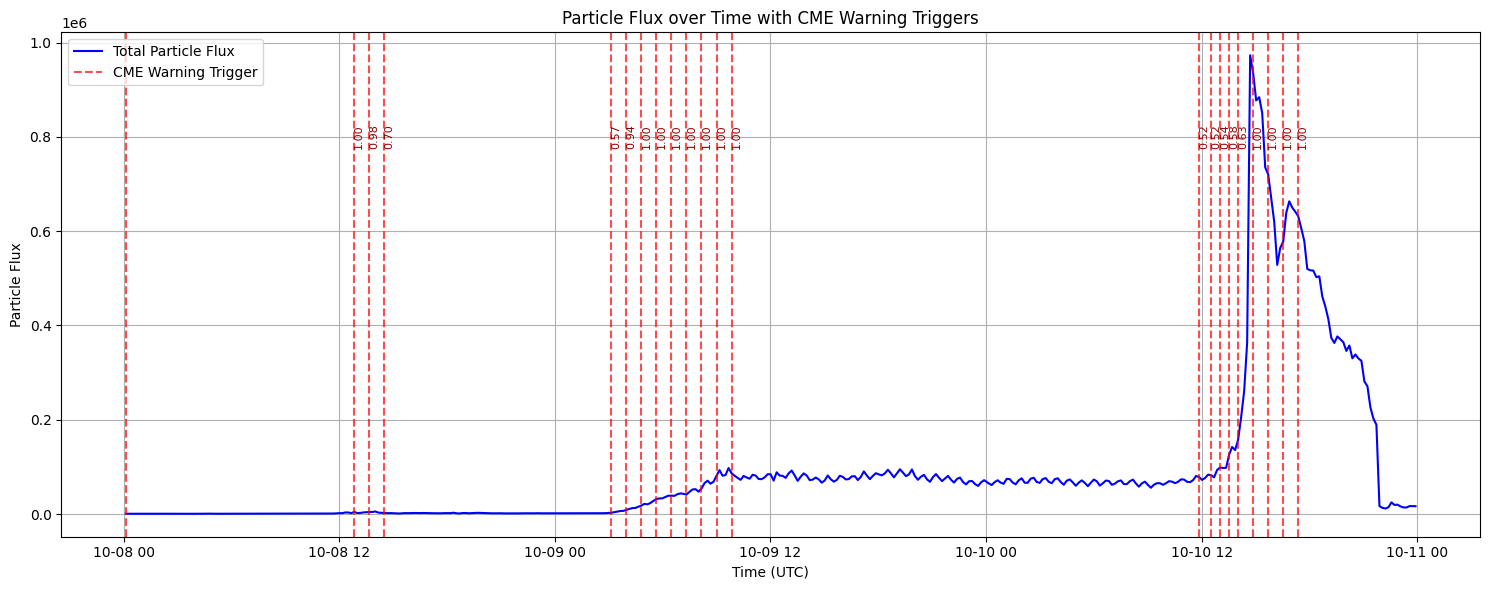

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot the total flux line
plt.plot(warning_system.steps_data.index,
         warning_system.steps_data['flux'],
         label='Total Particle Flux',
         color='blue')

# Plot a dummy line for legend (for red warning lines)
plt.axvline(warning_system.steps_data.index[0],
            color='red', linestyle='--', alpha=0.7, label='CME Warning Trigger')

# Overlay actual warning times with red dashed lines and confidence text
for w in warning_system.warnings:
    wt = pd.to_datetime(w['warning_time_utc'])
    plt.axvline(wt, color='red', linestyle='--', alpha=0.7)
    plt.text(wt, warning_system.steps_data['flux'].max() * 0.8,
             f"{w['confidence']:.2f}",
             rotation=90, fontsize=8, color='darkred')

# Formatting
plt.xlabel("Time (UTC)")
plt.ylabel("Particle Flux")
plt.title("Particle Flux over Time with CME Warning Triggers")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


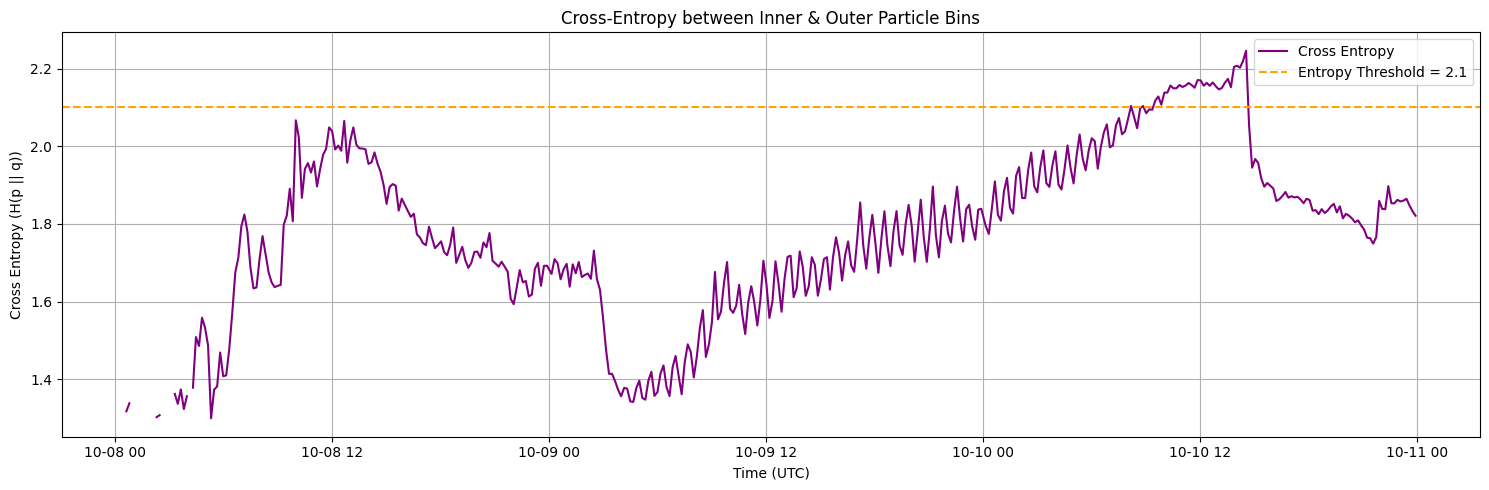

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(cross_entropy.cross_entropy_series.index, cross_entropy.cross_entropy_series, color='purple', label='Cross Entropy')

# Threshold
plt.axhline(2.1, color='orange', linestyle='--', label='Entropy Threshold = 2.1')

plt.xlabel("Time (UTC)")
plt.ylabel("Cross Entropy (H(p || q))")
plt.title("Cross-Entropy between Inner & Outer Particle Bins")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



🔍 Top 5 Cross-Entropy Timestamps (most asymmetric energy distributions):
time
2024-10-10 14:32:12+00:00    2.245811
2024-10-10 14:22:07+00:00    2.219449
2024-10-10 14:02:02+00:00    2.207059
2024-10-10 13:52:02+00:00    2.204122
2024-10-10 14:12:07+00:00    2.202345
Name: cross_entropy_inner_outer, dtype: float64


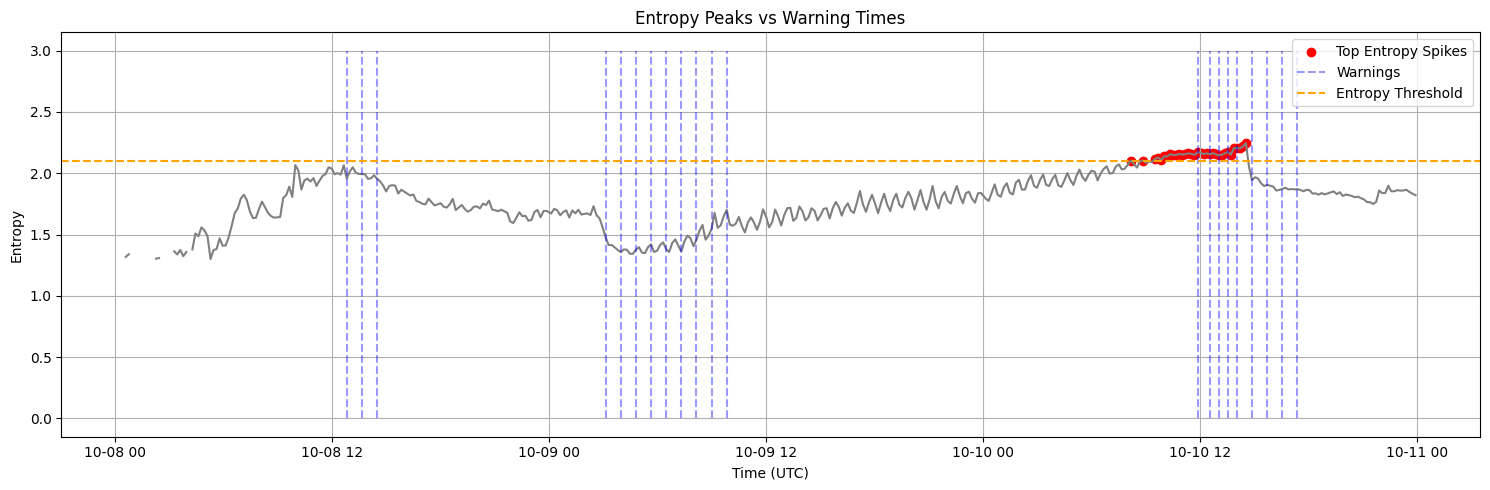

In [ ]:
top_entropy_times = cross_entropy.get_high_entropy_events(threshold=2.1)

plt.figure(figsize=(15, 5))
plt.plot(cross_entropy.cross_entropy_series.index, cross_entropy.cross_entropy_series, color='gray')
plt.scatter(top_entropy_times, cross_entropy.cross_entropy_series[top_entropy_times], color='red', label='Top Entropy Spikes')

# Mark warnings
warning_times = [pd.to_datetime(w['warning_time_utc']) for w in warning_system.warnings]
plt.vlines(warning_times, ymin=0, ymax=3, color='blue', linestyle='--', alpha=0.4, label='Warnings')

plt.axhline(2.1, color='orange', linestyle='--', label='Entropy Threshold')
plt.xlabel("Time (UTC)")
plt.ylabel("Entropy")
plt.title("Entropy Peaks vs Warning Times")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


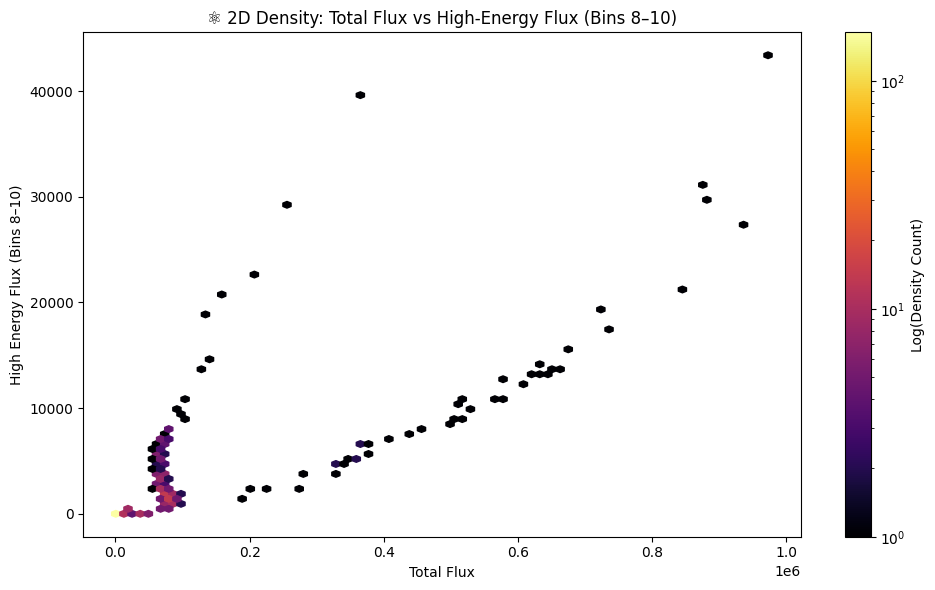

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you already have these two columns in your steps_data:
x = warning_system.steps_data['flux']
y = warning_system.steps_data['high_energy_flux']

plt.figure(figsize=(10, 6))

# Use log scale on color to show both low and high densities
hb = plt.hexbin(x, y, gridsize=80, cmap='inferno', bins='log')  # better color + log bins
cb = plt.colorbar(hb)
cb.set_label('Log(Density Count)')

plt.title("⚛️ 2D Density: Total Flux vs High-Energy Flux (Bins 8–10)")
plt.xlabel("Total Flux")
plt.ylabel("High Energy Flux (Bins 8–10)")
plt.tight_layout()
plt.show()



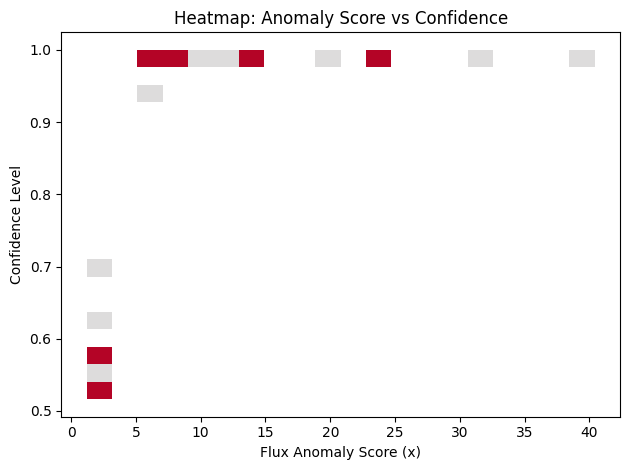

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame([
    {'score': float(w['particle_flux_anomaly'].split('x')[0]), 'confidence': w['confidence']}
    for w in warning_system.warnings
])

sns.histplot(data, x='score', y='confidence', bins=20, cmap="coolwarm")
plt.title("Heatmap: Anomaly Score vs Confidence")
plt.xlabel("Flux Anomaly Score (x)")
plt.ylabel("Confidence Level")
plt.tight_layout()
plt.show()
